# Загрузка данных из CSV файла в DataFrame.

In [2]:
import yfinance as yf

# Define the stock symbol
stock_symbol = 'BTC-USD'
stock = yf.Ticker(stock_symbol)
hist = stock.history(period="max")
df = hist.drop(columns=['Dividends', 'Stock Splits'])
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100


In [3]:
df['open'] = df['Open']
df['high'] = df['High']
df['low'] = df['Low']
df['close'] = df['Close']
df['volume'] = df['Volume']

In [4]:
# df = df.sort_values(by='date')
# df = df.reset_index(drop=True)
# df.head()

**Преобразование столбцов 'open', 'high', 'low' и 'close' в числовой формат.**

In [5]:
import pandas as pd
df['open'] = pd.to_numeric(df['open'])
df['high'] = pd.to_numeric(df['high'])
df['low'] = pd.to_numeric(df['low'])
df['close'] = pd.to_numeric(df['close'])

**Генерация графических паттернов из данных.**

In [6]:
import pandas as pd
import pandas_ta as ta

def generate_patterns(df):
    patterns = df.ta.cdl_pattern(name=['doji', 'inside'])
    patterns = patterns.replace(0, -5000)
    return patterns


In [7]:
def generate_cycles(df):
    cycles = pd.DataFrame(index=df.index)
    cycles['ebsw'] =ta.ebsw(df['close'])
    cycles['atr'] = ta.atr(df['high'], df['low'], df['close'], length=7)
    z = ta.cdl_z(df['open'], df['high'], df['low'], df['close'])
    cycles['open_z'] = z['open_Z_30_1']
    cycles['high_z'] = z['high_Z_30_1']
    cycles['low_z'] =  z['low_Z_30_1']
    cycles['close_z'] = z['close_Z_30_1']
   
    
    return cycles

**Генерация статистических показателей из данных.**

In [9]:
def generate_stats(df):
    t = 7
    stats = pd.DataFrame(index=df.index)
    
    stats['dev'] = ta.stdev(df['close'], length=t)
    stats['ema20'] = ta.ema(df['close'], length=20)
    stats['ema50'] = ta.ema(df['close'], length=50)
    # stats['ema100'] = ta.ema(df['close'], length=100)
    # stats['ema200'] = ta.ema(df['close'], length=200)
    stats['rsi6'] = ta.rsi(df['close'], length=6)
    stats['rsi12'] = ta.rsi(df['close'], length=12)
    stats['adx'] = ta.adx(df['high'], df['low'], df['close'], length=24)['ADX_24']
    # stats['sar'] = ta.sar(df['high'], df['low'])
    bbands = ta.bbands(df['close'], length=t, std=2.0)
    # print(bbands.columns)
    stats['b_upper'] = bbands['BBU_7_2.0']
    stats['b_middle'] = bbands['BBM_7_2.0']
    stats['b_lower'] = bbands['BBL_7_2.0']
    stats['percentage_difference'] = (df['high'] - df['low']) / df['low'] * 100
    stats['percentage_change'] = df['close'].pct_change()
    stats['min_price'] = df['close'].rolling(3).min()
    stats['max_price'] = df['close'].rolling(3).max()
    stats['next_day_close'] = df['close'].shift(-1)
    
    return stats

In [10]:
def generate_ind(df):
    t = 7
    stats = pd.DataFrame(index=df.index)

    stats['var'] = ta.variance(df['close'], length=t)
    a = ta.aroon(df['high'], df['low'], length=t)
    # stats['aroonD'], stats['aroonU'], stats['aroonSC'] = ta.aroon(df['high'], df['low'], length=t)
    stats['aroond'] = a['AROOND_7']
    stats['aroonu'] = a['AROONU_7']
    stats['aroonc'] = a['AROONOSC_7']
    # print(aroon.columns)
    # stats['aroon'] = aroon['Aroon Up'] - aroon['Aroon Down']
    stats['bop'] = ta.bop(df['open'], df['high'], df['low'], df['close'])
    stats['cci'] = ta.cci(df['high'], df['low'], df['close'], length=t)
    stats['mom'] = ta.mom(df['close'], length=t)
    stats['roc'] = ta.roc(df['close'], length=t) 
    # stats['rocp'] = ta.rocp(df['close'], length=t)
    stats['willr'] = ta.willr(df['high'], df['low'], df['close'], length=t)
    # stats = stats.astype(float)

    return stats

In [12]:
stats = generate_stats(df)
patterns = generate_patterns(df)
cycles = generate_cycles(df)
cycles_cols = cycles.columns.to_list()
indicators = generate_ind(df)
df = pd.concat([df, patterns], axis=1)
df = pd.concat([df, cycles], axis=1)
df = pd.concat([df, stats], axis=1)
df = pd.concat([df, indicators], axis=1)
df = df.dropna()
# df = df.reset_index(drop=True)

/tmp/ipykernel_15019/3209814288.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cycles['ebsw'] =ta.ebsw(df['close'])


**Использование PowerTransformer из библиотеки sklearn для нормализации указанных столбцов данных.**

In [14]:
from sklearn.preprocessing import PowerTransformer
import joblib

columns_norm = cycles_cols + indicators.columns.to_list() 
sc = PowerTransformer()
sc_params = sc.fit(df[columns_norm])
joblib.dump(sc, 'scaler.pkl')
df[columns_norm] = sc.transform(df[columns_norm])

In [15]:
features_l = ['high','low','close'] +  stats.columns.to_list()[:-1] + columns_norm + patterns.columns.to_list()

In [17]:
# df_test = df[df['date'] >= '2021-04-23'].reset_index()
# df = df[df['date'] <= '2021-04-23'].reset_index()
df_test = df[df.index >= '2024-03-11']
df = df[df.index <= '2024-03-11']

In [18]:
len(df)

3415

In [19]:
X_lin = df[features_l].values.reshape(df[features_l].shape[0], 1, df[features_l].shape[1])
X_test = df_test[features_l].values.reshape(df_test[features_l].shape[0], 1, df_test[features_l].shape[1])
X_test.shape

(92, 1, 33)

In [20]:
Y_lin = df['next_day_close'].values
Y_test = df_test['next_day_close'].values

In [21]:
from tensorflow.python.keras.backend import set_session
import tensorflow.compat.v1 as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
set_session(sess)


2024-06-12 21:38:42.813718: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-12 21:38:43.219168: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 21:38:43.219418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 21:38:43.294050: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-12 21:38:43.438750: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-12 21:38:43.441519: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [22]:
def r2_metric(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return (1 - SS_res / (SS_tot + tf.keras.backend.epsilon()))

In [23]:
X_lin.shape

(3415, 1, 33)

In [24]:
from keras.layers import Dense, LSTM, Input, Masking
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.regularizers import l2, l1
from keras.losses import MeanAbsolutePercentageError
from tensorflow.keras.models import Model
best_price = ModelCheckpoint('best_price2.keras', save_best_only=True, 
                            monitor='val_r2_metric', mode='max')

inputs_l = Input(shape=(X_lin.shape[1], X_lin.shape[2]))

masked_inputs_l = Masking(mask_value=-5000)(inputs_l)

hiddenl = LSTM(64, activation='linear', recurrent_activation='sigmoid',
                return_sequences=True)(masked_inputs_l)
hiddenl = LSTM(64, activation='linear', recurrent_activation='sigmoid',
                return_sequences=False)(hiddenl)

output_lin = Dense(1, activation='linear', name='lin')(hiddenl)
model = Model(inputs=inputs_l, outputs=output_lin)
# optimizer = Adam(amsgrad=True)

model.compile(optimizer='Adam',
              loss={ 'lin': MeanAbsolutePercentageError(name='loss')},
              metrics={'lin': [MeanAbsolutePercentageError(name='err'), r2_metric]})

model.fit(X_lin,Y_lin, epochs=500, batch_size=32, verbose=1, shuffle=False, 
        validation_data=[X_test, Y_test], callbacks=[best_price])

Epoch 1/500
107/107 [==============================] - 5s 11ms/step - loss: 21.7084 - err: 21.6724 - r2_metric: -50.2765 - val_loss: 2.7454 - val_err: 2.7047 - val_r2_metric: -0.3920
Epoch 2/500
107/107 [==============================] - 0s 5ms/step - loss: 19.1981 - err: 19.1655 - r2_metric: -71.0448 - val_loss: 3.0373 - val_err: 2.9937 - val_r2_metric: -0.6412
Epoch 3/500
107/107 [==============================] - 0s 5ms/step - loss: 11.3433 - err: 11.3304 - r2_metric: -17.0448 - val_loss: 2.9365 - val_err: 2.8952 - val_r2_metric: -0.5371
Epoch 4/500
107/107 [==============================] - 1s 5ms/step - loss: 11.4289 - err: 11.4171 - r2_metric: -18.4532 - val_loss: 2.6720 - val_err: 2.6359 - val_r2_metric: -0.2978
Epoch 5/500
107/107 [==============================] - 0s 4ms/step - loss: 12.2811 - err: 12.2646 - r2_metric: -21.8717 - val_loss: 2.9367 - val_err: 2.8984 - val_r2_metric: -0.5431
Epoch 6/500
107/107 [==============================] - 0s 4ms/step - loss: 12.7977 - err:

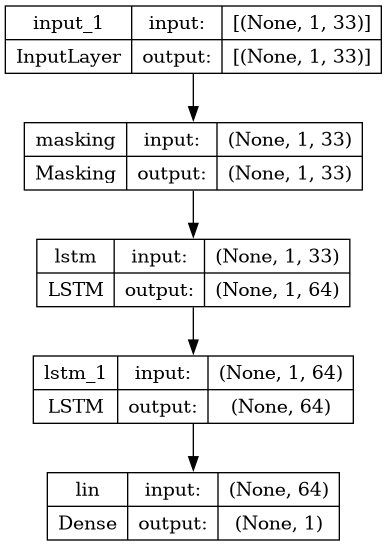

In [25]:

from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [26]:
from keras.models import load_model
model = load_model('best_price2.keras',custom_objects={'r2_metric': r2_metric})

In [28]:
predicted = model.predict(X_test)
df_test['predictions'] = predicted

Root Mean Squared Error: 1882.8007729711455
MAPE: 0.021324274427264457
MAE: 1408.9201341711957
r2: 0.6793162645909433


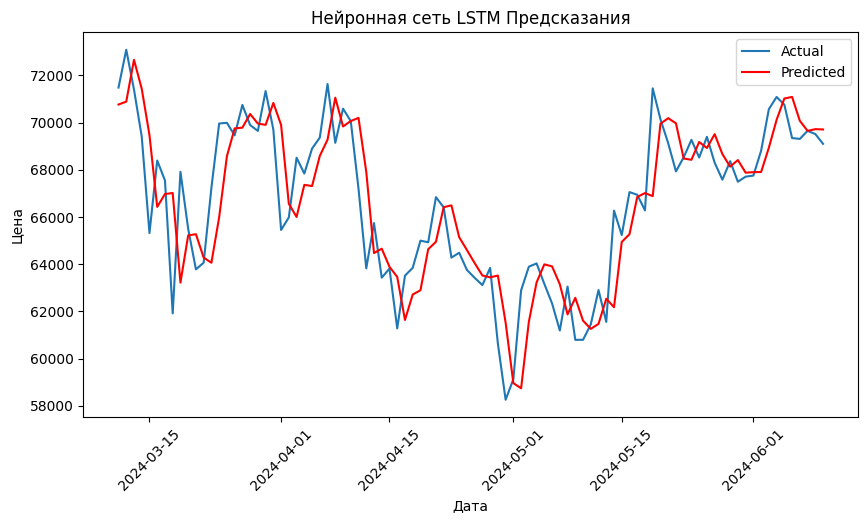

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np

predictions = df_test['predictions']
Y_test = df_test['next_day_close']

mse = mean_squared_error(df_test['next_day_close'], df_test['predictions'])
rmse = np.sqrt(mse)
print('Root Mean Squared Error:', rmse)
print("MAPE:", mean_absolute_percentage_error(Y_test, predictions))
print("MAE:", mean_absolute_error(Y_test, predictions))
print("r2:", r2_score(Y_test, predictions))
plt.figure(figsize=(10, 5))  
# Plotting with Matplotlib
plt.plot(df_test.index, df_test.next_day_close, label='Actual')
plt.plot(df_test.index, predictions, color='red', label='Predicted')
plt.title('Нейронная сеть LSTM Предсказания')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.xticks(rotation=45)
plt.legend()
plt.show()

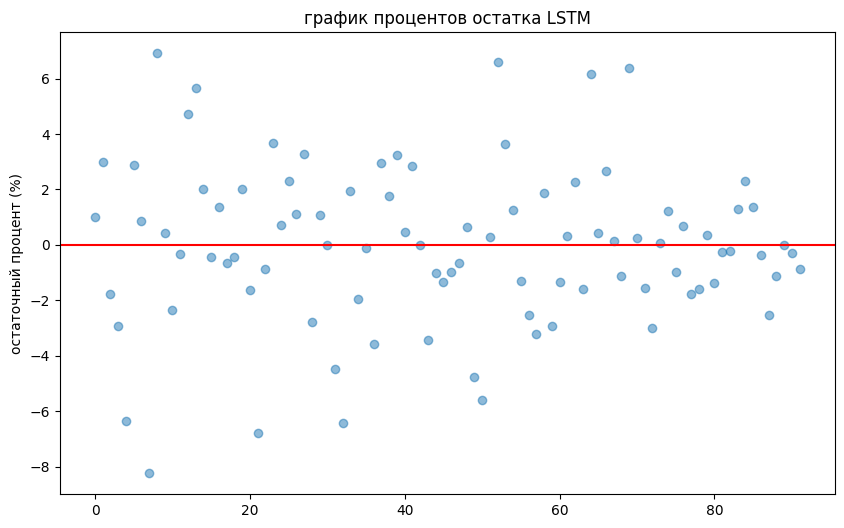

In [31]:
percent_residuals = 100 * (df_test['next_day_close']- predictions) / df_test['next_day_close']

plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(percent_residuals)), percent_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('график процентов остатка LSTM')
plt.ylabel('остаточный процент (%)')
plt.show()
